In [1]:

from qiskit import QuantumCircuit
from math import pi
from qiskit.circuit.library import QFTGate

def create_phase_estimation_circuit(num_precision_qubits: int, real_theta: float) -> QuantumCircuit:
    """
    Creates a generic phase estimation circuit using the 
    QFT (Quantum Fourier Transform) method given the amount of precision desired.
    Uses the Controlled Phase gate as the unitary operator for simplicity.
    """

    qc = QuantumCircuit(num_precision_qubits + 1, num_precision_qubits) # +1 for the eigenstate qubit

    # Initialize the eigenstate qubit to |1>
    qc.x(num_precision_qubits)  # Set the last qubit to |1>
    # Now we'll apply Hadamard gates to the precision qubits
    qc.h(range(num_precision_qubits))

    # Now we will apply the controlled-U operation which will be effectively a Phase gate
    for iteration, qubit in enumerate(range(num_precision_qubits)):
        angle = 2 * pi * real_theta * (2 ** iteration)
        qc.cp(angle, qubit, num_precision_qubits)  # Controlled Phase rotation

    qc.append(QFTGate(num_precision_qubits).inverse(), range(num_precision_qubits))
    qc.measure(range(num_precision_qubits), range(num_precision_qubits))

    return qc

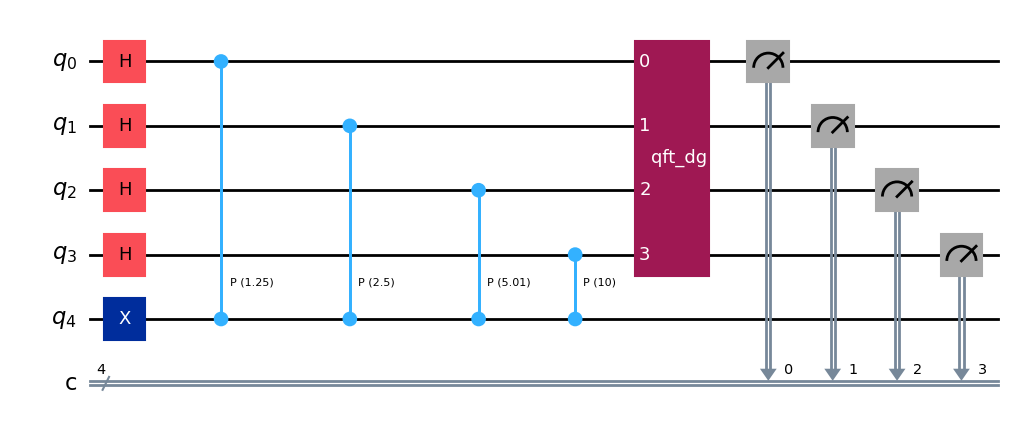

In [2]:
precision_num = 4
real_theta = 0.19932811
phase_estimation_circuit = create_phase_estimation_circuit(precision_num, real_theta)
phase_estimation_circuit.draw('mpl')

In [ ]:
from qiskit.primitives import StatevectorSampler
from quantum_studies.ibm_qpus import IBMQuantumRunner

EXECUTE_REAL_IBM_HARDWARE = True

if not EXECUTE_REAL_IBM_HARDWARE:
    sampler = StatevectorSampler()
    result = sampler.run([phase_estimation_circuit]).result()
    measurements = result[0].data.c.get_counts()
else:
    ibm_quantum_runner = IBMQuantumRunner("<API_KEY>")  # Replace <API_KEY> with your actual IBM Quantum API key
    ibm_quantum_runner.select_backend('ibm_torino')
    result = ibm_quantum_runner.run_circuit(phase_estimation_circuit, shots=1024 * 10, optimization_level=1)

measurements = result[0].data.c.get_counts()

print(measurements)

for outcome, count in measurements.items():
    print(f"Outcome: {outcome}, Count: {count}")
    # The expected outcome should be around the binary representation of 0.real_theta * 256 = 51, which is '00110011' in binary.

    # Transform the binary outcome to a decimal fraction
    decimal_value = int(outcome, 2) / (2 ** precision_num)
    print("Binary estimation:", outcome)
    print("Decimal estimation:", decimal_value)

Account saved successfully with ibm_quantum_platform channel!


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-21 10:07:19,884: Default instance not set. Searching all available instances.



Selected backend: ibm_torino
Number of qubits: 133
Backend status: active
Queue length: 726

Transpiled circuit depth: 133

Submitting job to ibm_torino...
Job ID: d37ssn0itjus73f6l9f0
Job status: QUEUED
{'0011': 6482, '0100': 729, '1011': 280, '0010': 561, '0001': 472, '0111': 205, '0101': 329, '0110': 110, '1111': 135, '1001': 93, '1000': 192, '0000': 316, '1101': 108, '1100': 92, '1010': 87, '1110': 49}
Outcome: 0011, Count: 6482
Binary estimation: 0011
Decimal estimation: 0.1875
Outcome: 0100, Count: 729
Binary estimation: 0100
Decimal estimation: 0.25
Outcome: 1011, Count: 280
Binary estimation: 1011
Decimal estimation: 0.6875
Outcome: 0010, Count: 561
Binary estimation: 0010
Decimal estimation: 0.125
Outcome: 0001, Count: 472
Binary estimation: 0001
Decimal estimation: 0.0625
Outcome: 0111, Count: 205
Binary estimation: 0111
Decimal estimation: 0.4375
Outcome: 0101, Count: 329
Binary estimation: 0101
Decimal estimation: 0.3125
Outcome: 0110, Count: 110
Binary estimation: 0110
De

Possible outcome states: ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
State with maximum count: 0011


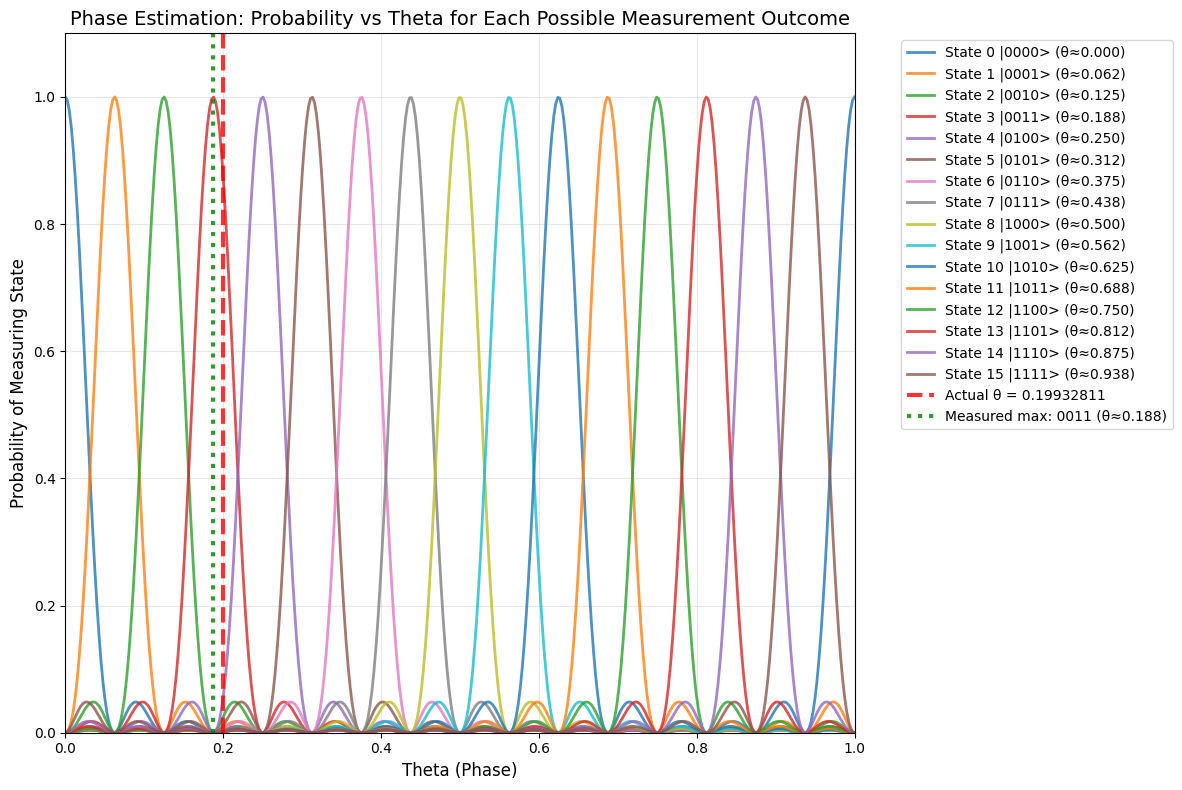

Actual theta: 0.199328
Best estimate (state 0011): 0.187500
Error: 0.011828
Weighted average estimate: 0.239490


In [4]:
possible_outcome_states = [format(i, f'0{precision_num}b') for i in range(2**precision_num)]
print("Possible outcome states:", possible_outcome_states)

state_with_max_count = max(measurements, key=measurements.get)
print("State with maximum count:", state_with_max_count)

import matplotlib.pyplot as plt
import numpy as np

# Create theta range from 0 to 1
theta_values = np.linspace(0, 1, 400)

plt.figure(figsize=(12, 8))

# Plot probability curves for each possible outcome state
for i, state in enumerate(possible_outcome_states):
    state_decimal = int(state, 2) / (2 ** precision_num)
    j = int(state, 2)  # decimal value of the binary state
    probabilities = []
    
    for theta in theta_values:
        # Calculate the actual quantum probability using the phase estimation formula
        # P(j|θ) = |sum_{k=0}^{N-1} exp(2πi(θ-j/N)k) / N|^2
        N = 2 ** precision_num
        
        # Calculate the sum for the probability amplitude
        if abs(theta - j/N) < 1e-10:  # theta exactly equals j/N
            prob = 1.0
        else:
            # Use the formula for geometric series sum
            phase_diff = 2 * np.pi * (theta - j/N)
            numerator = np.sin(N * phase_diff / 2)
            denominator = N * np.sin(phase_diff / 2)
            prob = (numerator / denominator) ** 2
        
        probabilities.append(prob)
    
    # Only plot states that have significant probability somewhere
    if max(probabilities) > 0.01:
        plt.plot(theta_values, probabilities, 
                label=f'State {j} |{state}> (θ≈{state_decimal:.3f})', 
                linewidth=2, alpha=0.8)

# Mark the actual theta value used in the circuit
plt.axvline(x=real_theta, color='red', linestyle='--', linewidth=3, 
           label=f'Actual θ = {real_theta}', alpha=0.8)

# Highlight the state with maximum count from measurements
max_state_decimal = int(state_with_max_count, 2) / (2 ** precision_num)
plt.axvline(x=max_state_decimal, color='green', linestyle=':', linewidth=3,
           label=f'Measured max: {state_with_max_count} (θ≈{max_state_decimal:.3f})', alpha=0.8)

plt.xlabel('Theta (Phase)', fontsize=12)
plt.ylabel('Probability of Measuring State', fontsize=12)
plt.title('Phase Estimation: Probability vs Theta for Each Possible Measurement Outcome', fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print comparison
print(f"Actual theta: {real_theta:.6f}")
print(f"Best estimate (state {state_with_max_count}): {max_state_decimal:.6f}")
print(f"Error: {abs(real_theta - max_state_decimal):.6f}")

# Average all outcomes weighted by their counts
total_counts = sum(measurements.values())
weighted_sum = sum((int(state, 2) / (2 ** precision_num)) *
                    count for state, count in measurements.items())
average_estimate = weighted_sum / total_counts
print(f"Weighted average estimate: {average_estimate:.6f}")